# Introduction
This notebook demonstrates how the NMR-onion algortimn works. The algoritmn is based around the steps of peak detection, digital filtering a region of interst (ROI), model fitting, model selection and uncertainty estimation 


first step is to load all the function requried to run the program. The import part is to set the path variable correctly to the folder where you have downloaded all the functions

In [34]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore", category=np.ComplexWarning)# disable plot warnings 
path="/home/mathies/Desktop/nmr onion/NMR onion final" # set your own path
sys.path.append(path)
# NMR onion functions
from data_import import import_data
from model_caller import onion_model_call,onion_bootstrap_call
from helper_functions import freq_hz,ppm_axis1,t_disrecte,time_series,ppm2hz,hz2ppm,amp_ratio,calc_couplings,result_csv,getoverlaps,count_overlaps
from model_prediction_fuctions import pred,preds_split,single_sinusoid,model_auto_select,par_hat_output
from peak_detection import peak_detection,peaks2hz,signal_points
from onion_filter_experimental import onion_filter,baseline_arPLS,data2fit

# Importing the data
To import processed bruker data from Topspin, the import_data function is called, here all one need to do is to set the data_path variable as /../dataset_name/exp_number/pdata/1. This will let you import the processed FID, Number of datapoints (N), sweep width in Hz (fs), transmitter position (O1), spectrometor frequecy (SF) and sweep width ppm (fs_ppm). additionally one can zerofill data if needed by stating true or false.

The time axis (s),frequency axis(hz) and frequency axis(ppm) is then automatically defined by calling the freq_hz,ppm_axis1,t_disrecte,time_series functions based on the import data output.


Currently only Bruker data is supported in this function for other formats the source code of the import function can be cominbed with other vendor formats by replacing the bruker import module from NMRglue with a different NMRglue module. Alternatively one may import a CSV file contaninig spectral data and do an inverse fourier transformation - more import options will be added in the futre

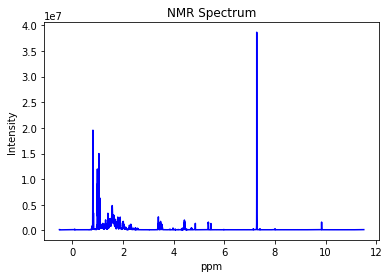

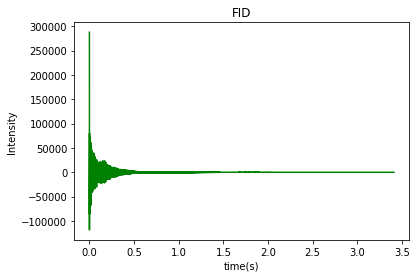

In [35]:
# set your own data_path
data_path="/home/mathies/Desktop/nmr onion/article data experiment 2/DTU800_150922_CHG_MMS052002(1)/DTU800_150922_CHG_MMS052002/10/pdata/1"
sys.path.append(data_path)

# import the data with needed process and aqusition parameters
# import data,data length, sample rate, O1, spectromtor frequency, sweep width (ppm), O1p, zerofill data if needed
data,N,fs,O1,SF,fs_ppm,O1p=import_data(path=data_path,zerofill=False)

# define discrete time (tn) and measure timed (t)
tn=t_disrecte(N)
t=time_series(tn=tn,fs=fs)

# define ppm axis
freq=freq_hz(tn=tn, fs=fs)
ppm_val=ppm_axis1(time=t, O1=O1, fs=fs, fs_ppm=fs_ppm)

# fourier transfrom raw data
fft_raw=np.fft.fftshift(np.fft.fft(data))

# check the data import works by plotting
plt.xlabel('ppm')  
plt.ylabel('Intensity')
plt.title("NMR Spectrum")  
plt.plot(ppm_val,fft_raw,color="blue")
#plt.xlim(,) # zoom x-axis
#plt.ylim(0,0.13*10**7) # zoom y-axis
plt.show()

# plot the time series
plt.title("FID")  
plt.plot(t,data,color="green")
plt.xlabel('time(s)')  
plt.ylabel('Intensity')
plt.show()

# Peak detection and ROI selection
Following data importing, selection of a ROI is requried for the alogrithm to work computationally effecient. Addtionally a good inital estimates of the frequency values must be given due to the mutimodal nature of the parameter space. The ROI is generated based on a digital filter which cuts out the ROI and adds synthetic noise outside the ROI. Here one needs to select the ROI and noise region for the filter to work. we choose 3.3:4.0 ppm for the ROI and -0.2:-0.1 for the noise region (other regions could also have been choosen). 

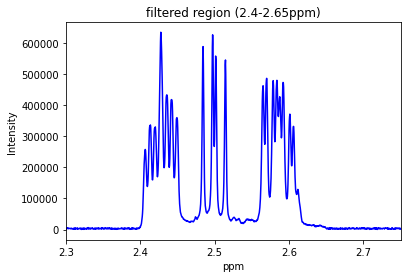

In [36]:
#filtering the data
ROI1=np.array([2.4,2.65])
target_ROI=ROI1

high_ppm=target_ROI[1]# set ppm values for region cuts
low_ppm=target_ROI[0]# set ppm values for region cuts

noise_region=[-0.2, -0.1,] # low to high ppm

# apply digital filter to get region of interest and estimated noise level
y_filt,noise_level=onion_filter(low_ppm, high_ppm, noise_region, data, fs, SF, O1p)

# fourier transform filtered data
y_fft_filt=np.fft.fftshift(np.fft.fft((y_filt)))

plt.xlabel('ppm')  
plt.ylabel('Intensity')
plt.title("filtered region ("+str(low_ppm)+"-"+str(high_ppm)+"ppm)",) 
plt.plot(ppm_val,y_fft_filt,color="blue")
plt.xlim(low_ppm-0.1,high_ppm+0.1)
plt.show()

When detecting peaks within the filtered regions. Two options may be applied, either use the peak detection algoritmn on filtered region to detect peaks or use the detection algorithmn on the full spectrum. In this case the filtred spectrum detection was applied. Three parameters are given for the detection algorithmn that is a width parameter, noise_roi and noise_peaks.

Witdh: Controls how large a witdh based on the fwhm of the peaks should be indculeded in the detection. defualt valus is set at 1.0, higher values decrease number of peaks detected (reasonable range:0.8:2.5)

noise_roi: Controls how large the error margin for the automated signal detection should be. defualt value is set at 4, lower values increase number of peaks detected (reasonable range: 1.0:4.0)

noise_peaks: Controls how large the noise floor should be. defualt value set at 2.0, lowering number increases peaks detected, increasing number decreases number of peaks detected (reasonable range: 1.0:20)

Alternatively the safety net of SNR (in dB) is also included such that no peaks below a certain SNR is included

Prior to detection an addtional baseline correction might be needed using the ALSpls algoritmn which requries the input of a lamba value. the defualt value is set at lam=10^5 and this usually works well in tandem with the detection algoritmn. For this dataset it was not needed.

/home/mathies/Desktop/nmr onion/NMR onion final/onion_filter_experimental.py:141: RuntimeWarning: overflow encountered in exp
  w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))
/home/mathies/Desktop/nmr onion/NMR onion final/onion_filter_experimental.py:141: RuntimeWarning: invalid value encountered in true_divide
  w_new = 1 / (1 + np.exp(2 * (d - (2*s - m))/s))


0.999 0.98651123046875
0.998 0.98651123046875
0.997 0.98651123046875
0.996 0.98651123046875
0.995 0.98651123046875
0.994 0.98651123046875
0.993 0.98651123046875
0.992 0.98651123046875
0.991 0.98651123046875
0.99 0.98651123046875
0.989 0.98651123046875
0.988 0.98651123046875
0.987 0.98651123046875
0.986 0.98651123046875
0.999 0.98651123046875
0.998 0.98651123046875
0.997 0.98651123046875
0.996 0.98651123046875
0.995 0.98651123046875
0.994 0.98651123046875
0.993 0.98651123046875
0.992 0.98651123046875
0.991 0.98651123046875
0.99 0.98651123046875
0.989 0.98651123046875
0.988 0.98651123046875
0.987 0.98651123046875
0.986 0.98651123046875
0.999 0.98651123046875
0.998 0.98651123046875
0.997 0.98651123046875
0.996 0.98651123046875
0.995 0.98651123046875
0.994 0.98651123046875
0.993 0.98651123046875
0.992 0.98651123046875
0.991 0.98651123046875
0.99 0.98651123046875
0.989 0.98651123046875
0.988 0.98651123046875
0.987 0.98651123046875
0.986 0.98651123046875


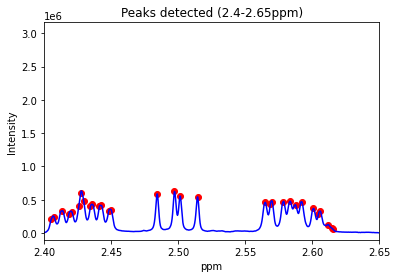

In [37]:
# baseline correction of full spectrum
_, fft_raw_als, info = baseline_arPLS(fft_raw, lam=1e5, niter=20,
                                        full_output=True)

# baseline correction of filtered spectrum
_, y_fft_filt_als, info = baseline_arPLS(fft_raw, lam=1e5, niter=20,
                                        full_output=True)
# detect peaks in ppm
omega_ppm=peak_detection(ppm_val=ppm_val, y=y_fft_filt, width=1.0, noise_roi=4, noise_peaks=5, t=t, fs=fs)

# convert detected peaks to hz
omega_hz_filtered=peaks2hz(omega_ppm,high_ppm,low_ppm,SF,O1p) # convert to hz and make sure only peaks within ROI is present
    
# store the detected peak intensitiy values and ppm/hz values (set ppm_out=True for ppm output, else hz output)
ROI_hz_points,ROI_signal_points=signal_points(omega_hz_filtered=omega_hz_filtered, freq=freq, y=y_filt, SF=SF, O1p=O1p,ppm_out=False)

ROI_ppm_points=hz2ppm(np.array(ROI_hz_points),SF,O1p) # point values in ppm


# compute SNR in dB
SNR_db=np.log10(ROI_signal_points/np.std(noise_level))
idx=np.where(np.real(SNR_db)>0)

omega_hz_filtered=omega_hz_filtered[idx]

# return SNR filtered omega
omega_hz_filtered=omega_hz_filtered[idx]

# check the peak dection within the region
plt.xlabel('ppm')  
plt.ylabel('Intensity')
plt.title("Peaks detected ("+str(low_ppm)+"-"+str(high_ppm)+"ppm)",) 
plt.plot(ppm_val,y_fft_filt,color="blue")
plt.xlim(low_ppm,high_ppm)
plt.ylim(-100000,1*10**6.5)
for i in range(0,len(omega_hz_filtered)):
    plt.scatter(ROI_ppm_points[idx[0][i]],ROI_signal_points[idx[0][i]],color="red")


# Running the models and model selection
The NMR onion includes 3 models of which the best is selected, being either the skewed lortentzian model, skewed psedou voigt model or the skewed generlized voigt model.in the future the fitting process will be run in parallel. it shoudl be noted that it is also possible to compare with non-skewed versions of models by setting model name as "pvoigt","lorentzian" or "genvoigt" instead. Each model is run with 20 epochs and a learning rate of 0.1 and an exponential learning rate scheduler is applied to lower the learning rate per epoch

The model selection is based of AIC and BIC from which the lowest value is choosen, pointing back to a specfic model. This is done by the model_auto_selection function, one can either choose this to be based on BIC (defualt) or or AIC by setting BIC=False. A table is also provided should it be needed to see the actualt BIC and AIC values

For this dataset, the ROI was best fitted by the skewed generlized voigt model. The restuls of the best model is stored as par_res for the parameter values, k for the number of components detected and model for the best model name

In [19]:
# lortentzian model
fit1=onion_model_call(model_name="skewed_lorentzian",omega_hz_filtered=omega_hz_filtered,tn_new=tn,t_new=t,fs_new=fs,y_norm=y_filt/np.linalg.norm(y_filt))

tensor(0.0986, dtype=torch.float64, grad_fn=<AsStridedBackward0>)
loss: 0.09857021662118388
loss: 0.09837684236890977
loss: 0.09837490832169628
loss: 0.09837488898120673
loss: 0.09837488878780618
loss: 0.09837488878587916
loss: 0.0983748887858465
loss: 0.09837488878584637
loss: 0.09837488878584638
loss: 0.09818126146406339
loss: 0.09817932516917013
loss: 0.098179305806235
loss: 0.0981793056125967
loss: 0.09817930561066059
loss: 0.09817930561064128
loss: 0.09817930561064114
loss: 0.09817930561064114
loss: 0.09798551530387503
loss: 0.09798357764636008
loss: 0.0979835582698255
loss: 0.09798355807605615
loss: 0.09798355807411821
loss: 0.09798355807409959
loss: 0.09798355807409949
loss: 0.09798355807409949
loss: 0.09798355807409949
Epoch:01/20 Loss: 9.79836e-02
loss: 0.09798355807409949
loss: 0.09784784003625291
loss: 0.09784648307378246
loss: 0.0978464695041725
loss: 0.0978464693684834
loss: 0.09784646936712152
loss: 0.09784646936710743
loss: 0.09784646936710732
loss: 0.09784646936710732
l

In [39]:
# psedou voigt model
fit2=fit2=onion_model_call(model_name="skewed_pvoigt",omega_hz_filtered=omega_hz_filtered,tn_new=tn,t_new=t,fs_new=fs,y_norm=y_filt/np.linalg.norm(y_filt))

loss: 0.09480575060716177
loss: 0.09346214280771713
loss: 0.09344872364981367
loss: 0.09344858946097466
loss: 0.09344858811907907
loss: 0.09344858810566373
loss: 0.09344858810552328
loss: 0.0934485881055223
loss: 0.09344858810552233
loss: 0.09209338902406013
loss: 0.09207987177408801
loss: 0.09207973660574338
loss: 0.09207973525405314
loss: 0.0920797352405389
loss: 0.09207973524039904
loss: 0.0920797352403981
loss: 0.0920797352403981
loss: 0.09071774828151309
loss: 0.09070417061010404
loss: 0.0907040348380677
loss: 0.09070403348034939
loss: 0.09070403346677197
loss: 0.09070403346664205
loss: 0.09070403346664102
loss: 0.09070403346664101
loss: 0.09070403346664101
loss: 0.09070403346664101
Epoch:01/20 Loss: 9.07040e-02
loss: 0.09070403346664101
loss: 0.08974630885463115
loss: 0.0897367529149463
loss: 0.08973665735782732
loss: 0.08973665640225637
loss: 0.08973665639269808
loss: 0.0897366563926076
loss: 0.08973665639260693
loss: 0.08973665639260693
loss: 0.08877688143737743
loss: 0.0887673

In [20]:
# genererlized voigt
fit3=onion_model_call(model_name="skewed_genvoigt",omega_hz_filtered=omega_hz_filtered,tn_new=tn,t_new=t,fs_new=fs,y_norm=y_filt/np.linalg.norm(y_filt))

loss: 0.09857928794168448
loss: 0.09663334878630571
loss: 0.09661402244092097
loss: 0.0966138291983566
loss: 0.09661382726593097
loss: 0.09661382724660844
loss: 0.09661382724641877
loss: 0.09661382724641819
loss: 0.09661382724641819
loss: 0.09469550317688095
loss: 0.0946765690140987
loss: 0.09467637970012541
loss: 0.09467637780698236
loss: 0.09467637778806148
loss: 0.09467637778785797
loss: 0.09467637778785659
loss: 0.09467637778785658
loss: 0.09467637778785658
loss: 0.09280438653354371
loss: 0.0927858666592554
loss: 0.0927856814804207
loss: 0.09278567962863445
loss: 0.09278567961011874
loss: 0.09278567960992704
loss: 0.09278567960992568
loss: 0.09278567960992565
loss: 0.09278567960992565
loss: 0.09278567960992565
Epoch:01/20 Loss: 9.27857e-02
loss: 0.09278567960992565
loss: 0.09148565657215972
loss: 0.09147270289938944
loss: 0.09147257336710597
loss: 0.0914725720717794
loss: 0.09147257205883108
loss: 0.0914725720586997
loss: 0.0914725720586987
loss: 0.09147257205869867
loss: 0.0914725

In [40]:
# find parameter error of best model
model_compare_BIC=np.array([fit1['BIC_model'],fit2['BIC_model'],fit3['BIC_model']])
model_compare_AIC=np.array([fit1['AIC_model'],fit2['AIC_model'],fit3['AIC_model']])

model_compare_table=pd.DataFrame(({'skewed_lorentzian':(model_compare_BIC[0],model_compare_AIC[0]),
               'skewed_psedou_voigt':(model_compare_BIC[1],model_compare_AIC[1]),
               'skewed_generlized_voigt':(model_compare_BIC[2],model_compare_AIC[2]),
    }))

# make a list of fits
fits=([fit1,fit2,fit3])

par_res,model,k=model_auto_select(model_compare_BIC,model_compare_AIC,fits,omega_hz_filtered,BIC=True)
print(model_compare_BIC) # print BIC values
print(model_compare_AIC) # print AIC values
print(model) # print the best model name

[-595123.26344305 -773328.78786757 -731824.57146965]
[-596871.14407681 -775659.29537925 -734155.07898133]
skewed_pvoigt


# Model output
Now that each model has been fitted and the best model is choosen, the next step is to extract the relvant parameters for ROI identification and view how well the model predicted the spectrum. Each value for the model is extracted as seen below. Both in the Hertz domain (O1 not added) and in the ppm domain 

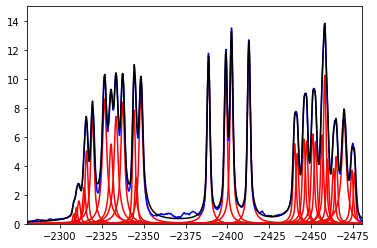

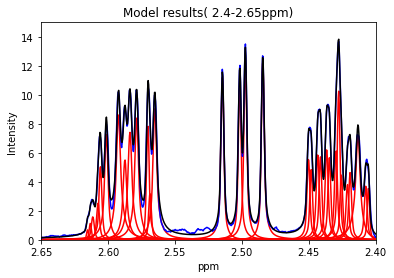

In [43]:
# get parameter output as vector  
par_hat=par_hat_output(best_model=model,par_res=par_res)

# get FID prediction
y_hat=pred(theta=par_hat,m=k,t=t,y=y_filt/np.linalg.norm(y_filt), model_name=model)

# get individual sinusoids 
single_sinusoids=single_sinusoid(theta=par_hat,m=k,t=t,y=y_filt/np.linalg.norm(y_filt), model_name=model)
A,Z=preds_split(theta=par_hat,m=k,t=t,y=y_filt/np.linalg.norm(y_filt), model_name=model)

# optional parameters amplitude and phase
phases=np.arctan2(np.imag(A),np.real(A)) #phase
amps=np.abs(A) # amplitudes

# view results in the time domain
plt.plot(t,y_filt,color="blue")
plt.plot(t,y_hat,color="black")
#plt.plot(t,y_filt-y_hat) # uncomment to view residuals

# define results in frequency domain
y_fft_hat=np.fft.fftshift(np.fft.fft(y_hat)) # fft of FID prediction
y_fft_cut=np.fft.fftshift(np.fft.fft(y_filt/np.linalg.norm(y_filt))) # fft of decimated FID 
y_fft_resi=y_fft_cut-y_fft_hat # residuals of the frequency domain 

# plot the results in hertz
for i in range(0,k):
     plt.plot(freq,(np.fft.fftshift(np.fft.fft(single_sinusoids[i]))),color="red")
plt.plot(freq,y_fft_cut,color="blue")
plt.plot(freq,(y_fft_hat),color="black")
#plt.plot(freq,(y_fft_resi),color="orange") # incude resuduals to the plot by uncommenting
plt.xlim(ppm2hz(high_ppm,SF,O1p), ppm2hz(low_ppm,SF,O1p))
plt.ylim(0,15)
plt.show()

# get results in ppm
omega=par_res['omega_est'] # extract frequency estimated in hz, it is also possible to find any other parameter this way

# plot results in ppm
ppm_val=ppm_axis1(time=t, O1=O1, fs=fs, fs_ppm=fs_ppm)
omega_ppm=hz2ppm(omega_hz=omega, SF=SF, O1p=O1p)

for i in range(0,k):
    plt.plot(ppm_val,np.fft.fftshift(np.fft.fft(single_sinusoids[i])),color="red")
plt.plot(ppm_val,(y_fft_cut),color="blue")
plt.plot(ppm_val,(y_fft_hat),color='black')
#plt.plot(ppm_val,(y_fft_resi),color="orange") # incude resuduals to the plot by uncommenting
plt.xlim(high_ppm,low_ppm)
plt.ylim(0,15)
plt.xlabel('ppm')  
plt.ylabel('Intensity')
plt.title("Model results( "+str(low_ppm)+"-"+str(high_ppm)+"ppm)", ) 
plt.show()

It is also possible to get error of the estimated parameters, this is done by estimating a confidence interval at a user defined level (set CI_level from 0 to 1) and a standard error for each parameter based on B number of bootstrap samples (set B from 1 to inf, recommend B=1000). This might take a while deepending on the size of the ROI, in the futre this will be done in parallel to speed up the process.

In [44]:
# get the bootstrap samples for each parameter
boot_samples=onion_bootstrap_call(B=1000,par_hat=par_hat,low_ppm=low_ppm,high_ppm=high_ppm,model_name=model, CI_level=0.95,SF=SF,O1p=O1p,freq=freq,fs=fs, t=t, k=k, y=y_filt/np.linalg.norm(y_filt))

# collect results in a table
res_uncertantinty=pd.DataFrame(({'omega_hz_error':boot_samples['omega_std'],
                                'omega_hz_CI_lower':boot_samples['omega_CI_lower']+O1,
                                'omega_hz_CI_upper':boot_samples['omega_CI_upper']+O1,
                                'omega_ppm_error':hz2ppm(omega_hz=boot_samples['omega_boot'], SF=SF, O1p=O1p).T.std(),
                                'omega_ppm_CI_lower':hz2ppm(omega_hz=boot_samples['omega_CI_lower'], SF=SF, O1p=O1p),
                                'omega_ppm_CI_upper':hz2ppm(omega_hz=boot_samples['omega_CI_lower'], SF=SF, O1p=O1p)
    }))


Epoch:01/epochs Loss: 1.74661e-01
0
Epoch:01/epochs Loss: 1.65268e-01
1
Epoch:01/epochs Loss: 3.84743e-01
2
Epoch:01/epochs Loss: 5.69542e-02
3
Epoch:01/epochs Loss: 1.31561e-01
4
Epoch:01/epochs Loss: 3.20566e-01
5
Epoch:01/epochs Loss: 1.96547e-02
6
Epoch:01/epochs Loss: 3.41058e-03
7
Epoch:01/epochs Loss: 4.02627e-01
8
Epoch:01/epochs Loss: 6.39337e-01
9
Epoch:01/epochs Loss: 3.88396e-01
10
Epoch:01/epochs Loss: 4.56310e-01
11
Epoch:01/epochs Loss: 1.80252e-01
12
Epoch:01/epochs Loss: 2.90018e-01
13
Epoch:01/epochs Loss: 1.34453e-01
14
Epoch:01/epochs Loss: 2.98347e-01
15
Epoch:01/epochs Loss: 3.29459e-01
16
Epoch:01/epochs Loss: 5.14185e-01
17
Epoch:01/epochs Loss: 4.51777e-01
18
Epoch:01/epochs Loss: 6.40311e-01
19
Epoch:01/epochs Loss: 4.22801e-03
20
Epoch:01/epochs Loss: 5.28170e-01
21
Epoch:01/epochs Loss: 1.36500e-04
22
Epoch:01/epochs Loss: 6.64444e-01
23
Epoch:01/epochs Loss: 2.64077e-01
24
Epoch:01/epochs Loss: 4.84452e-01
25
Epoch:01/epochs Loss: 4.85348e-01
26
Epoch:01/ep

KeyError: 'boot_omega'

Finally one may collect all key results and import these in a seperate folder generating one CSV per ROI. the CSV contains a coupling matrix, parameter estimates, that is frequency (hz and ppm), amplitude ratios, uncertainties of the frequencies.

One can do some slight altering to get all the model paramters in the CSV, but per default we keep these out as they are not very meaningfull when interperting data as they contribute mainly to the amplitude ratio estimations.

The content of a ROI is shown below to increase understanding. To extract the results from python, the function of result_csv is called to get a CSV of the wanted ROI containing the output of the above dataframes.

In [46]:
# the content of the CSV showcased

# couptling pattern matrix 
j_mat=calc_couplings(omega=omega, k=k)

# count the overlaps
overlaps=count_overlaps(idx_list, k) 

# amplitudes ratio
amp_ratios=amp_ratio(peaks=single_sinusoids, k=k)

boot_samples['omega_std'].index=range(k)

#table of uncertainties
res_uncertantinty=pd.DataFrame(({'omega_hz_error':boot_samples['omega_std'],
                                'omega_hz_CI_lower':boot_samples['omega_CI_lower']+O1,
                                'omega_hz_CI_upper':boot_samples['omega_CI_upper']+O1,
                                'omega_ppm_error':hz2ppm(omega_hz=boot_samples['omega_boot'], SF=SF, O1p=O1p).T.std(),
                                'omega_ppm_CI_lower':hz2ppm(omega_hz=boot_samples['omega_CI_lower'], SF=SF, O1p=O1p),
                                'omega_ppm_CI_upper':hz2ppm(omega_hz=boot_samples['omega_CI_upper'], SF=SF, O1p=O1p)
    }))
res_uncertantinty.index = range(k)


# table of regional results
res_region=pd.DataFrame(({'amp_ratio':amp_ratios,
                         'omega_hz':omega+O1,
                         'omega_ppm':omega_ppm,
                         'overlaps': overlaps,
                         }))

res_combo=pd.concat([res_region,res_uncertantinty,j_mat],axis=1)

#result_csv(single_sinusoids,boot_samples,k,omega,SF,j_mat,O1,O1p)

Note to interpret the coupling matrix, the diagnoal elements represents the current peak marked with a 0 and the off diagnoals are the distances bewteen the current peak and the peaks sourounding it. 

A last fearure one can get after extacting the results are the plotting of parameter uncertainties. It is possible to plot view where potential false peaks are located in in a given ROI. These are marked by a green dot. one can also plot the boostrap samples of a particular peak if needed to view potenital overlaps, here we are showing the peak at peaks around 2.57 ppm. At the moment this is done manually, but in the future an automation will be made.

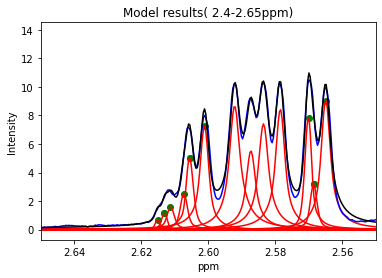

In [51]:
# plot results in ppm
omega=par_res['omega_est'] # frequency estimated in hz

j_mat=calc_couplings(omega=omega, k=k) # coupling pattern matrix 

# plot results in ppm
ppm_val=ppm_axis1(time=t, O1=O1, fs=fs, fs_ppm=fs_ppm)
omega_ppm=hz2ppm(omega_hz=omega, SF=SF, O1p=O1p)
idx_list=getoverlaps(boot_samples,omega_ppm, k)

for i in range(0,k):
    plt.plot(ppm_val,np.fft.fftshift(np.fft.fft(single_sinusoids[i])),color="red")
for i in range(0,len(idx_list)):
    ppm_cord_idx=np.argmax(np.fft.fftshift(np.fft.fft(single_sinusoids[idx_list[i]])))
    plt.scatter(ppm_val[ppm_cord_idx],max(np.fft.fftshift(np.fft.fft(single_sinusoids[idx_list[i]]))),color="green")   
plt.plot(ppm_val,(y_fft_cut),color="blue")
plt.plot(ppm_val,(y_fft_hat),color='black')
#plt.plot(ppm_val,(y_fft_resi),color="orange")
plt.xlim(high_ppm,low_ppm)
plt.xlim(2.65,2.55)
#plt.ylim(0,60)
plt.xlabel('ppm')  
plt.ylabel('Intensity')
#
plt.title("Model results( "+str(low_ppm)+"-"+str(high_ppm)+"ppm)", ) 
plt.show()

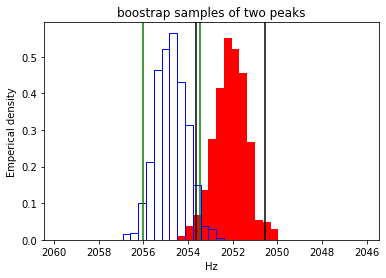

In [55]:
# plot the CI of a desired peak
omega_samples=boot_samples['omega_boot']
omega_samples.index = range(k)

df_max=omega_samples.T.max(axis=1).max()+O1
df_min=omega_samples.T.min(axis=1).min()+O1

sub_roi_CIl=res_combo['omega_hz_CI_lower']
sub_roi_CIu=res_combo['omega_hz_CI_upper']

sub_roi_CIl.index = range(k)
sub_roi_CIu.index = range(k)

_, bins, _ = plt.hist(omega_samples.T[idx_list[0]], bins=500,range=(df_min,df_max))
plt.title("boostrap samples of two peaks")
plt.xlabel("Hz")
plt.ylabel("Emperical density")
plt.xlim(-2340+O1,-2355+O1) # set the plot limits in Hz 
_= plt.hist(omega_samples.T[idx_list[14]]+O1,color="r", bins=bins,density=True)  # you have to know the number of the peak you are looking for
_= plt.hist(omega_samples.T[idx_list[15]]+O1,ec="b",fc="none", bins=bins,density=True)    
plt.axvline(sub_roi_CIl[idx_list[15]],color="green")
plt.axvline(sub_roi_CIu[idx_list[15]],color="green")
plt.axvline(sub_roi_CIl[idx_list[14]],color="black")
plt.axvline(sub_roi_CIu[idx_list[14]],color="black")
plt.show()